In [1]:
%load_ext autoreload
%autoreload 2
%pwd

'/home/oli/Research/Joe/agent-goals/code'

In [2]:
from matplotlib import pyplot as plt

import numpy as np
np.set_printoptions(precision=3)
import torch

from pdg.dist import RawJointDist, CPT
from pdg.rv import Variable, binvar, Unit
from pdg.lib import A,B,C,D
from pdg.pdg import PDG

from pdg.utils import nparray_of as narr

In [3]:
from pdg.lib import square

In [4]:
M = square.with_rand_cpts
M.hypergraph_object

(['A', 'B', 'C', 'D'],
 {'p1': [['B', 'C'], ['A']],
  'p2': [['A', 'D'], ['B']],
  'p3': [['A', 'D'], ['C']],
  'p4': [['B', 'C'], ['D']]})

In [5]:
M

In [6]:
square.consist_with_P.hypergraph_object

(['A', 'B', 'C', 'D'],
 {'p1': [['B', 'C'], ['A']],
  'p2': [['A', 'D'], ['B']],
  'p3': [['A', 'D'], ['C']],
  'p4': [['B', 'C'], ['D']]})

# Finding multiple points consistent with it
The idea is to find a lot of points in Inc(M), some which maximize and minimize IDef, and plot them together with the fixed point from Gibbs Sampling.

(['A', 'B', 'C'],
 {'p1': [['A', 'C'], ['B']], 'p2': [['B'], ['A']], 'p3': [['B'], ['C']]})

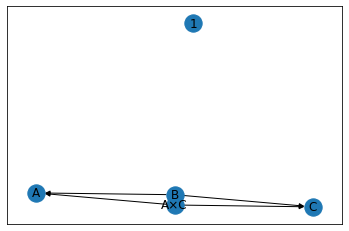

In [7]:
Q = PDG()
Q += A, B, C
Q += B|(A&C), A|B, C|B

mu = Q.genΔ()
M = Q.make_edge_mask(mu)

M.draw()
M.hypergraph_object

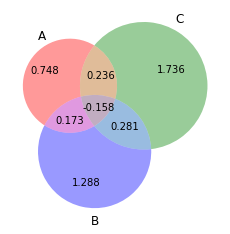

In [8]:
mu.info_diagram(A,C,B)

In [9]:
mu2 = M.iter_GS_beta()

In [10]:
muopt = M.optimize_score(0.00001)

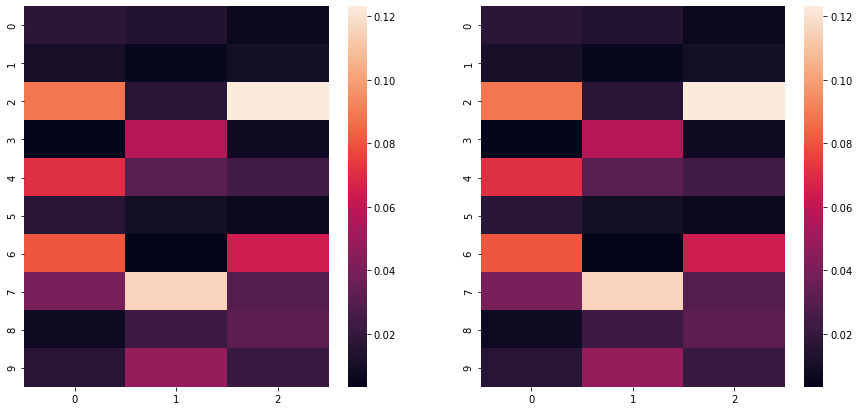

In [11]:
import seaborn as sns
fig, (ax1, ax2) = plt.subplots(1,2,figsize=(15,7))
sns.heatmap(muopt[A&C, B].to_numpy().reshape(len(A)*len(C), len(B)), ax=ax1)
sns.heatmap(mu[A&C, B].to_numpy().reshape(len(A)*len(C), len(B)), ax=ax2)

In [12]:
# The two are very close, but not identical:
print("square error",  ((mu.data-muopt.data)**2).sum() )
print("relative entropies",  mu // muopt,  muopt // mu )

square error 1.0325502392738214e-09
relative entropies 1.316030114461735e-08 1.3160746189422666e-08


In [13]:
L = M.standard_library()

In [14]:
from pdg.dist import RawJointDist as RJD
L.decoder = lambda vec : RJD(vec, M.varlist)

In [15]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)

pca.fit( np.vstack([ t for S,t in L.raw ]) )

PCA(n_components=2)

In [16]:
L.tags

{'GS', 'gibbs', 'i', 'opt', 'ordered', 'product', 'β', 'γ', 'φ', '≺'}

In [17]:
X,Y = pca.transform(np.vstack([dist.data.reshape(-1) for dist in L('opt').without('i').along('γ')])).T

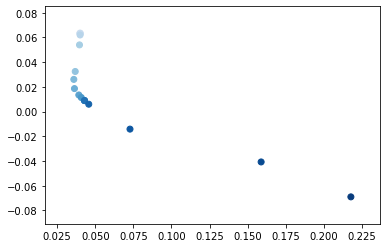

In [18]:
from matplotlib.cm import get_cmap
cmap = get_cmap("Blues")
plt.scatter(X,Y, c=cmap(np.linspace(0.0,0.95,len(X))))
plt.show()

In [19]:
from pdg.distviz import pca_view

Explained_variance: [1.000e+00 2.601e-15] 	(total: 1.000000)


array([[[ 4.710e-11,  1.591e-11, -4.535e-11,  5.696e-12, -8.253e-11],
        [ 3.492e-11,  7.287e-12, -3.097e-12,  8.433e-11, -4.896e-11],
        [ 2.044e-11,  1.129e-11, -4.540e-11,  2.029e-11, -3.912e-11]],

       [[-5.815e-11, -4.346e-11,  2.289e-11, -9.507e-12,  2.253e-11],
        [-2.728e-11, -2.223e-12,  7.838e-11, -1.658e-11,  7.223e-11],
        [-2.605e-11, -2.322e-11,  1.703e-11, -2.233e-11,  3.292e-11]]])

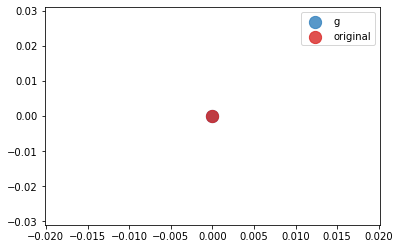

In [20]:
pca_view( g = [+ L('opt',γ=0).without('i')] ,  original=[mu.data])
(+ L('opt',γ=0).without('i')).data - mu.data

In [24]:
L.tag_sort(M.IDef)
None

In [85]:
t = torch.tensor([[[0.0000, 0.0114, 0.1129, 0.0000, 0.0959],
         [0.0000, 0.0061, 0.0212, 0.0121, 0.0458],
         [0.0000, 0.0099, 0.1514, 0.0000, 0.0377]],
        [[0.0376, 0.0936, 0.0284, 0.0125, 0.0054],
         [0.0192, 0.0000, 0.0760, 0.0396, 0.0153],
         [0.0150, 0.0747, 0.0205, 0.0495, 0.0084]]])

rjt = RJD(t, M.varlist, use_torch=True)


np.isfinite(rjt.prob_matrix(B|A,C))

tensor([[[0, 1, 1, 1, 1],
         [0, 1, 1, 1, 1],
         [0, 1, 1, 1, 1]],

        [[1, 1, 1, 1, 1],
         [1, 1, 1, 1, 1],
         [1, 1, 1, 1, 1]]], dtype=torch.uint8)

In [278]:
mu_torch_converted = RJD(mu.data, mu.varlist, use_torch=True)
muopt_torch_converted = RJD(muopt.data, mu.varlist, use_torch=True)
M.torch_score(mu_torch_converted, 0), M.torch_score(muopt_torch_converted, 0)

# mu_torch_converted.prob_matrix(B|A,C)
# mu_torch_converted.data.sum(dim=[])
# mu[B|A&C] - M[B|A&C]
# mu.H(...)

(tensor(9.1352e-17), tensor(2.4069e-10))

# Optimization Playground

In [338]:
# torch.autograd.set_detect_anomaly(False)
mu_opt_torch, iterates, losses = M._torch_opt_inc(0,iters=3000, ret_iterates=True)
# plt.plot([np.log(l)/np.log(10) for l in losses])
min(losses)

[2999/3000]  loss:  3.119e-11;  lr: 8.734e-04

1.444267937429427e-15

In [229]:
1E7*(iterates[0]- iterates[70])

tensor([[[0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0.]],

        [[0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0.]]], dtype=torch.float64)

mat [[[0.017 0.015 0.007]
  [0.011 0.005 0.01 ]
  [0.089 0.016 0.123]
  [0.003 0.057 0.008]
  [0.071 0.032 0.024]]

 [[0.017 0.01  0.007]
  [0.081 0.003 0.064]
  [0.039 0.116 0.029]
  [0.007 0.022 0.032]
  [0.016 0.048 0.021]]]
mat tensor([[[0.0123, 0.0105, 0.0050],
         [0.0079, 0.0038, 0.0069],
         [0.0643, 0.0116, 0.0893],
         [0.0025, 0.0415, 0.0056],
         [0.0513, 0.0230, 0.0176]],

        [[0.0121, 0.0071, 0.0047],
         [0.0587, 0.0024, 0.0466],
         [0.0286, 0.0839, 0.0211],
         [0.0054, 0.0160, 0.0231],
         [0.0116, 0.0351, 0.0154]]], dtype=torch.float64)


/home/oli/Research/Joe/agent-goals/code/pdg/dist.py:166: UserWarning: 0.08-Unnormalized CPT
  warnings.warn("%.2f-Unnormalized CPT"%amt)


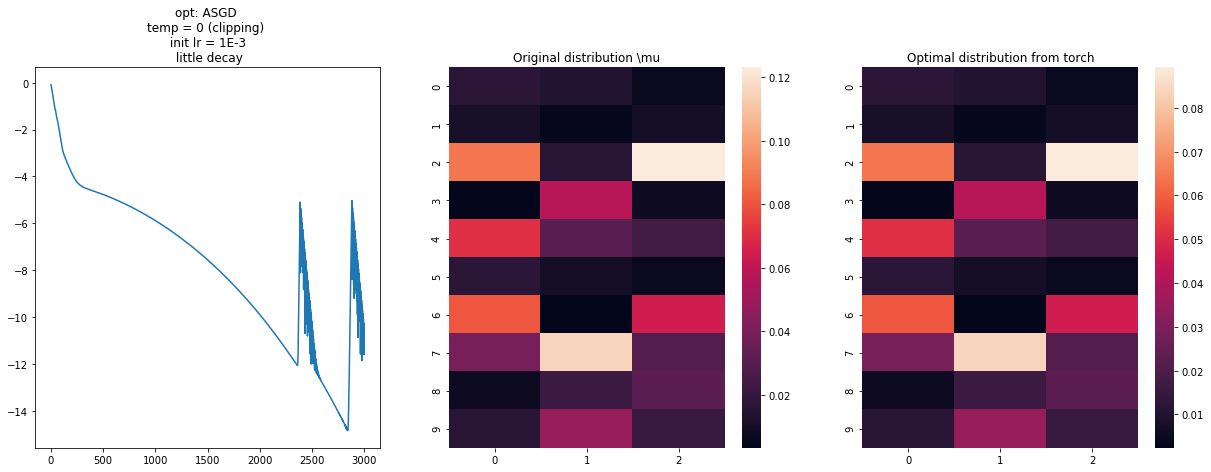

In [339]:
fig, (ax0,ax1, ax2) = plt.subplots(1,3,figsize=(21,7))

ax0.plot([np.log(l)/np.log(10) for l in losses])
ax0.set_title("opt: Adam \ntemp = 0 (clipping) \n init lr = 1E-3 \n little decay")

ax1.set_title("Original distribution \\mu")
ax2.set_title("Optimal distribution from torch")
sns.heatmap(muopt[A&C, B].to_numpy().reshape(len(A)*len(C), len(B)), ax=ax1)
# sns.heatmap(mu[A&C, B].to_numpy().reshape(len(A)*len(C), len(B)), ax=ax2)
# sns.heatmap(mu_opt_torch.prob_matrix(A&C, B).numpy().reshape(len(A)*len(C), len(B)), ax=ax3)
# mu_opt_torch[A&C, B]
# sns.heatmap(mu_opt_torch.prob_matrix(A&C, B).numpy().reshape(len(A)*len(C), len(B)), ax=ax2)
sns.heatmap(mu_opt_torch[A&C, B].to_numpy().reshape(len(A)*len(C), len(B)), ax=ax2)



In [ ]:
pt_inc(0,iters=2000)
plt.plot([np.log(l)/np.log(10) for l in losses])
plt.set_title("")

In [29]:
M.torch_score(muopt)

tensor([[[nan, nan, nan, nan, nan],
         [nan, nan, nan, nan, nan],
         [nan, nan, nan, nan, nan]],

        [[nan, nan, nan, nan, nan],
         [nan, nan, nan, nan, nan],
         [nan, nan, nan, nan, nan]]], dtype=torch.float64)

In [240]:
test = RJD(M.genΔ().data, M.varlist, use_torch=True)
P = test.prob_matrix(B|A)
D = test.data
torch.log( torch.where(P==0,1.,P))*D

tensor([[[-0.0218, -0.0255, -0.0461, -0.0112, -0.0440],
         [-0.0549, -0.0341, -0.0148, -0.0088, -0.0443],
         [-0.0287, -0.0196, -0.0159, -0.0123, -0.0805]],

        [[-0.0025, -0.1127, -0.0161, -0.0090, -0.0300],
         [-0.0066, -0.0102, -0.1200, -0.0219, -0.0025],
         [-0.0184, -0.0074, -0.0711, -0.0189, -0.0639]]], dtype=torch.float64)

In [230]:
type(1E-204)

float